# Keyrir Strætó of hratt?: Samanburður keyrsluhraðagagna frá Strætó API-inu við hámarkshraðagögn

_**Árni Dagur Guðmundsson**: arni@dagur.eu | Menntaskólinn við Hamrahlíð_

## Inngangur:

### API
Falið í kóða heimasíðu Strætó má finna API (forritaskil) sem geyma ýmsar upplýsingar um staka strætisvagna í rauntíma. Strætó appið notar þetta API meðal annars til að sýna staðsetningu strætisvagna á korti. Ég bjó til einfaldan Python pakka sem kallar á API-ið og spýtir út niðurstöðunum í JSON. Hér fyrir neðan sést niðurstaða einfalds kalls:

In [1]:
from straeto import api
api.getBusPositionsFor(["55"])[0]

{'deviceNumber': 208,
 'route': '55-A',
 'gpsTime': '180512163353',
 'lat': 63.999095,
 'lon': -22.5573666666667,
 'speed': 24.38,
 'heading': 329.06,
 'gpsFix': 2,
 'routeNumber': '55',
 'lastStop': 20000134,
 'nextStop': 20000022,
 'pingCode': 6}

Eins og sést býður API-ið upp á breiddargráðu (_lat_), og lengdargráðu (_lon_). Því er til dæmis hægt að birta staðsetningu allra strætisvagna landsins á kort líkt og svo:

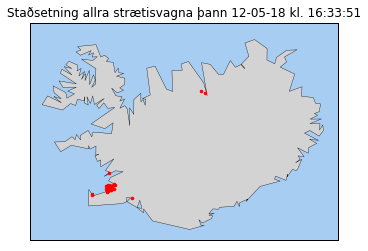

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import warnings; warnings.filterwarnings('ignore')
from datetime import datetime

map = Basemap(projection='merc', resolution='l',
              urcrnrlat=66.8,urcrnrlon=-12.9,
              llcrnrlat=63.2, llcrnrlon=-25)
map.drawcoastlines(linewidth=0.35)
map.fillcontinents(color='lightgrey', lake_color='#a7cdf2')
map.drawmapboundary(fill_color='#a7cdf2')

for bus in api.getAllBusPositions():
    X, Y = map(bus['lon'], bus['lat'])
    map.plot(X, Y, 'ro', markersize=2.5)

plt.title('Staðsetning allra strætisvagna þann {}'.format(datetime.now().strftime('%d-%m-%y kl. %H:%M:%S')))
plt.show()

Hraðinn er einnig til staðar en ekki vitum við þó hvaða mælieining notuð er til þess að mæla hann.

$k\cdot v_{api} = v \Rightarrow k = \frac{v}{v_{api}}$

In [ ]:
from straeto import straeto
bdict, p_bdict = straeto.getConsecutiveBuses(ratio=0.5)

print(len(bdict),len(p_bdict))

In [4]:
from geopy.distance import geodesic
from datetime import datetime as dt
G = []
B = []
Ks = []
for key in bdict:
    bus = bdict[key]; p_bus = p_bdict[key]
    t_1 = dt.strptime(bus['gpsTime'],"%y%m%d%H%M%S"); t_2 = dt.strptime(p_bus['gpsTime'],"%y%m%d%H%M%S")
    delta_t = (t_1-t_2).total_seconds()
    delta_s = geodesic((bus['lat'], bus['lon']), (p_bus['lat'], p_bus['lon'])).km

    kmh = (delta_s/delta_t)*3600
    avg_speed = (1/2)*(bus['speed']+p_bus['speed'])

    k = kmh/avg_speed
    Ks.append(k)
    dic = {
        'speed_0': p_bus['speed'],
        'speed_1': bus['speed'],
        'delta_s': delta_s,
        'delta_t': delta_t,
        'kmh': kmh,
        'avg_speed': avg_speed,
        'route': bus['route'],
        'k': k
    }
    if 1.7 < k < 1.9:
        G.append(dic)
    else:
        B.append(dic)

print('Good:')
for i in G:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
print('Bad:')
for i in B:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
avg_k = sum(Ks)/len(Ks)
print(avg_k)


Good:
14-C | k = 27.81 / 15.85 = 1.75 | 9.85 --> 21.85
52-A | k = 57.85 / 30.63 = 1.89 | 27.12 --> 34.14
4-D | k = 14.55 / 7.96 = 1.83 | 8.37 --> 7.54
1-A | k = 19.03 / 11.08 = 1.72 | 10.18 --> 11.98
A6 | k = 31.41 / 17.37 = 1.81 | 16.43 --> 18.31
5-B | k = 33.84 / 17.86 = 1.9 | 11.55 --> 24.16
57-D | k = 10.7 / 6.04 = 1.77 | 5.69 --> 6.4
51-E | k = 87.0 / 47.22 = 1.84 | 47.13 --> 47.31
57-A | k = 95.0 / 51.97 = 1.83 | 52.1 --> 51.84
23-A | k = 31.05 / 17.38 = 1.79 | 24.15 --> 10.62
57-B | k = 98.7 / 54.49 = 1.81 | 55.36 --> 53.62
3-C | k = 35.3 / 20.73 = 1.7 | 18.16 --> 23.3
55-A | k = 26.51 / 14.5 = 1.83 | 24.38 --> 4.63
Bad:
1-B | k = 27.34 / 8.15 = 3.35 | 11.28 --> 5.03
17-A | k = 15.49 / 9.96 = 1.56 | 9.93 --> 9.98
28-A | k = 16.25 / 15.29 = 1.06 | 12.63 --> 17.95
1-E | k = 20.65 / 10.72 = 1.93 | 10.76 --> 10.69
43-B | k = 29.14 / 15.07 = 1.93 | 12.77 --> 17.38
15-B | k = 76.44 / 39.28 = 1.95 | 33.22 --> 45.34
2-C | k = 23.19 / 11.23 = 2.06 | 5.9 --> 16.57
21-A | k = 36.99 / 18.19

## Undirbúningur gagna:

```
ALTER TABLE buses ADD COLUMN geom Geometry(Point, 4326);
```
svo:
```
UPDATE buses SET geom=ST_SetSrid(ST_MakePoint(lon, lat), 4326);
```

```
SELECT r.maxspeed FROM roads r, buses b WHERE ST_DWithin(b.geom, r.geom, 8) ORDER BY ST_Distance(r.geom, b.geom);
```

In [5]:
!ls

extract_roads  readme.md  straeto  straeto-notebook.ipynb
